## 17-7-Accuracy_and_errors in the spam filter

### Naive Bayes: spam filter
- building a spam filter
- There should be spam/ham labels. In this data this is done for us.


In [1]:
#### import necessary files

%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### # Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
             "master/sms_spam_collection/SMSSpamCollection"
            )
sms_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

In [4]:
### lets look at the data
sms_raw

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


#### Data analysis
- we have two columns, a label and a message.
- We have to get features from this data.  Now, a message isn't really a feature. However, we can engineer features from the message field relatively easily. This kind of feature engineering is a basic version of what we'll cover in the NLP section.
- At the most obvious level, a feature from the message can be whether it contains a given word. These words could be keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent'] etc.

- Let's add those columns to our dataframe. The words chosen below are simply intuited as possibly having something to do with spam. Try some of your own ideas too!
- Note that you could add new features to the dataframe simply by adding them to the keywords list. 

In [7]:
keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent']

### lets look at the message and see if the message has any of these words. if they do, possibility of spam
for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    sms_raw[str(key)] = sms_raw.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [6]:
### 
sms_raw

,spam,message,click,offer,winner,buy,free,cash,urgent
0,ham,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,False,False,False
3,ham,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,False,False,False,False,False,False,False
5568,ham,Will ü b going to esplanade fr home?,False,False,False,False,False,False,False
5569,ham,"Pity, * was in mood for that. So...any other s...",False,False,False,False,False,False,False
5570,ham,The guy did some bitching but I acted like i'd...,False,False,False,False,False,False,False


#### Data analysis
- Another feature option would be if the message is all uppercase. That seems kind of spammy doesn't it?

In [8]:
### is themessage all uppercase?
sms_raw['allcaps'] = sms_raw.message.str.isupper()

In [9]:
# Before we go further, let's turn the spam column into a boolean so we can easily 
# do some statistics to prepare for modeling.

sms_raw['spam'] = (sms_raw['spam'] == 'spam')
# Note that if you run this cell a second time everything will become false.
# So... Don't.

In [10]:
sms_raw

,spam,message,click,offer,winner,buy,free,cash,urgent,allcaps
0,False,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False
1,False,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,False,False,False,False
3,False,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False,False
4,False,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
5567,True,This is the 2nd time we have tried 2 contact u...,False,False,False,False,False,False,False,False
5568,False,Will ü b going to esplanade fr home?,False,False,False,False,False,False,False,False
5569,False,"Pity, * was in mood for that. So...any other s...",False,False,False,False,False,False,False,False
5570,False,The guy did some bitching but I acted like i'd...,False,False,False,False,False,False,False,False


### Naive Bayes assumptions
- Now, as we covered before one of the main assumptions of Naive Bayes is that the variables fed into the model are independent of each other. 
- Let's check to see how true that is in this case using Pandas' built in correlation matrix function, corr(), and the heatmap from seaborn.

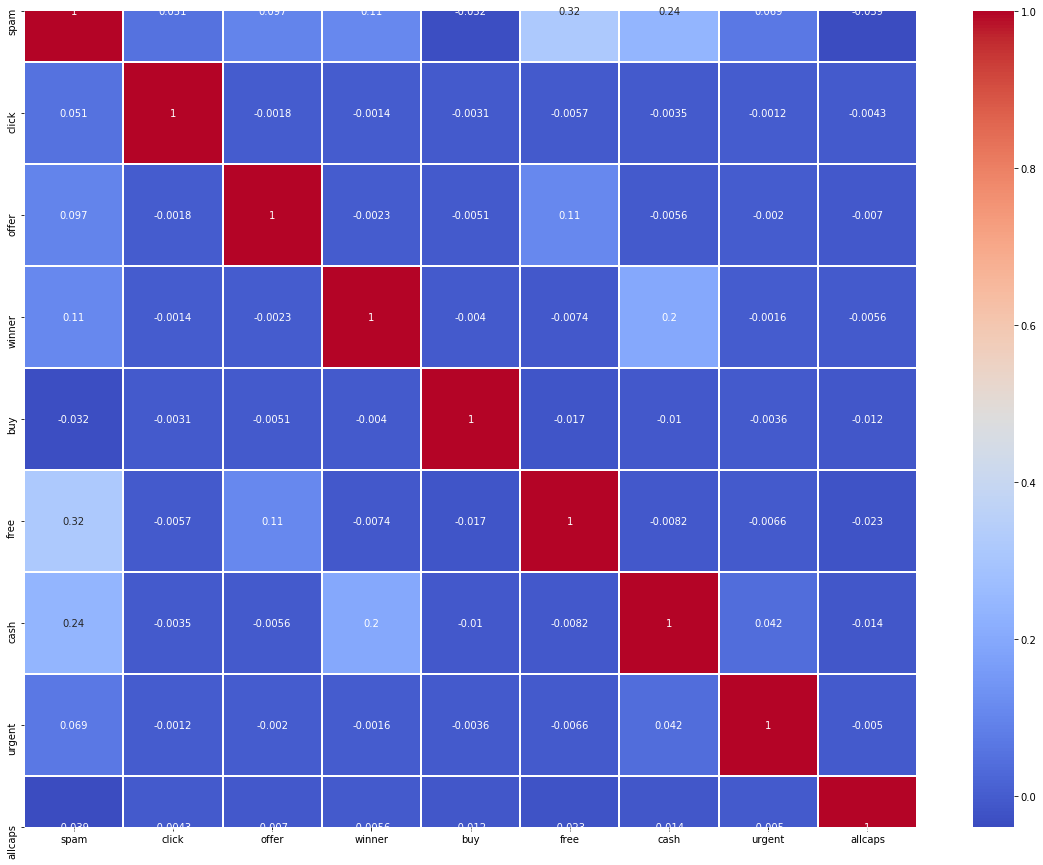

In [17]:
plt.figure(figsize=(20,15))
sns.heatmap(sms_raw.corr(), linewidth=1,annot=True,cmap='coolwarm')
plt.show()

### 
- Most of the words show strong independence from each other. The only exceptions are free:offer and cash:winner

### Building model: Pick out your training data


In [19]:
### Training data
# SKLearn required you to specify an outcome (y or dependent variable) 
# and your inputs (x or independent variables). 
# We'll do that below under the titles data and target.

data = sms_raw[keywords + ['allcaps']]
target = sms_raw['spam']

In [22]:
#data

In [23]:
#target

### Create Model

In [24]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 5572 points : 604


## How accurate is your model?

In [ ]:
# Calculate the accuracy of your model here.
# Display our results.
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%".format(
    data.shape[0],
    (target != y_pred).sum(),
    100*(1-(target != y_pred).sum()/data.shape[0])
))



## using confusiion matrix from sklearn

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

## Find your TN, FP, FN, TP manually

In [ ]:
# Build your confusion matrix and calculate sensitivity and specificity here.
#cm = [[TN, FP],[FN, TP]] - true negetive, false positive, false negetive, true positive

def manually_calculate_cm(test_y, test_predictions):
    """Manually create confusion matrix by comparing predictions with answers."""
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    x = 0
    while x < len(test_y):
        if test_y[x] == 0 and test_predictions[x] == 0:
            TN += 1
        if test_y[x] == 0 and test_predictions[x] == 1:
            FP += 1
        if test_y[x] == 1 and test_predictions[x] == 1:
            TP += 1
        if test_y[x] == 1 and test_predictions[x] == 0:
            FN += 1
        x += 1

    cm = [[TN, FP],[FN, TP]]
    return cm



In [ ]:
manual = manually_calculate_cm(target, y_pred)

#print("\nsklearn cm:", data)
print("Manual:", manual)

### Manual: [[4770, 55], [549, 198]]

## Magda question
- do we always create manual confusion matrix?
- is it not ok to use the built in one?